In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# reading both datasets
train = pd.read_csv(r'C:\Users\sreeh\MLAI\Datasets\train_loan.csv')

In [3]:
# Checking the train dataset
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
# Checking for missing values in the Train dataset
train.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [5]:
# Checking the datatypes of the columns in the Train dataset.
train.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [6]:
# Checking the unique values present in Dependent columns. Ideally it should have been a numerical column.
train['Dependents'].unique()

array(['0', '1', '2', '3+', nan], dtype=object)

In [7]:
# We will consider Dependents column as string for filling missing values and then change it to numerical.
# Creating a function to fetch Object features which has null values.
def get_object_cols_with_null(df):
    object_cols = df.select_dtypes(include=['object']).columns.tolist()
    cols_with_null = []
    for col in object_cols:
        if df[col].isnull().any():
            cols_with_null.append(col)
    return cols_with_null

In [8]:
# Fill the categorical features in train dataset with mode.
train_na_cols = get_object_cols_with_null(train)
for col in train_na_cols:
    train[col].fillna(train[col].mode()[0], inplace=True)

In [9]:
train.isnull().sum()

Loan_ID               0
Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [10]:
# Check the type of values in Loan Amount Term
train['Loan_Amount_Term'].value_counts()

Loan_Amount_Term
360.0    512
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: count, dtype: int64

Since we have few repeating values and not a continous numerical value, we will use mode to fill the missing values.

In [11]:
train['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].mode()[0],inplace=True)

In [12]:
# Similarly check the Credit history in=the dataset.
train['Credit_History'].value_counts()

Credit_History
1.0    475
0.0     89
Name: count, dtype: int64

In [13]:
# Fill Credit History in both using mode.
train['Credit_History'].fillna(train['Credit_History'].mode()[0],inplace=True)

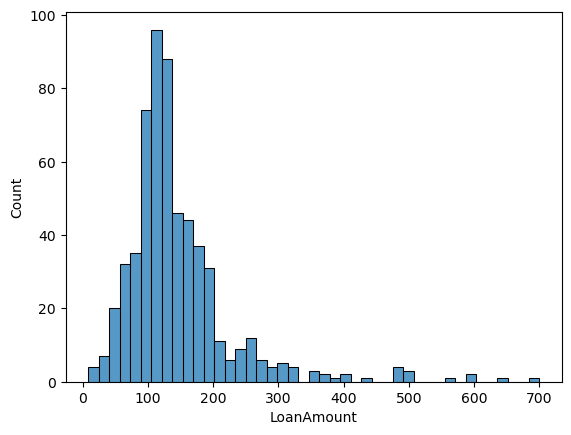

In [14]:
# Check the distribution of Loan Amount
sns.histplot(train['LoanAmount'])
plt.show()

In [15]:
# Since the distribution is right-skewed using median to fill the null values
train['LoanAmount'].fillna(train['LoanAmount'].median(), inplace=True)

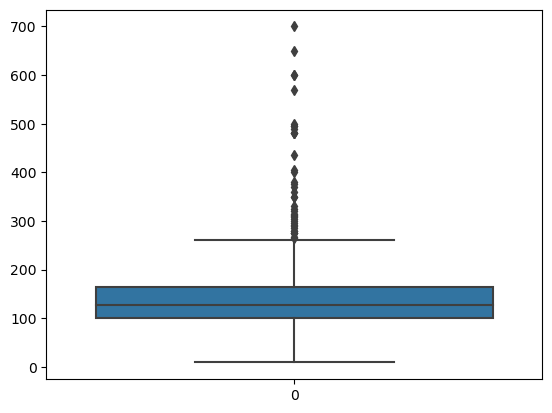

In [16]:
# Check whether there are outliers in LoanAmount
sns.boxplot(data=train['LoanAmount'])
plt.show()

In [17]:
# To keep all the values we use log function to change the shape of the data.
train['LoanAmount_log'] = np.log(train['LoanAmount'])

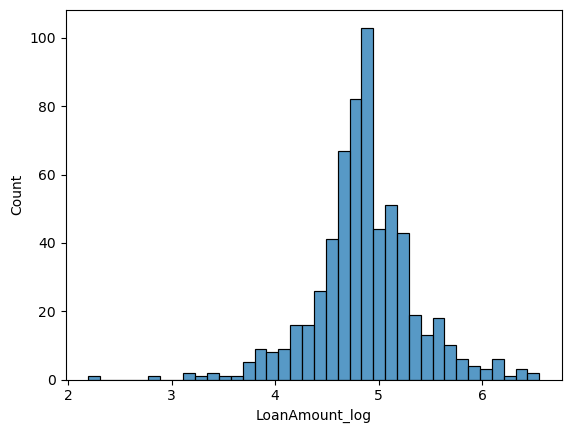

In [18]:
# Check the distribution of Loan Amount Log
sns.histplot(train['LoanAmount_log'])
plt.show()

In [19]:
train.drop('LoanAmount', axis =1, inplace = True)

In [20]:
# Rather that 2 separate columns, we can have a single Total Income column
train['TotalIncome']=train['ApplicantIncome']+train['CoapplicantIncome']
train.drop(train[['ApplicantIncome','CoapplicantIncome']],axis=1,inplace=True)

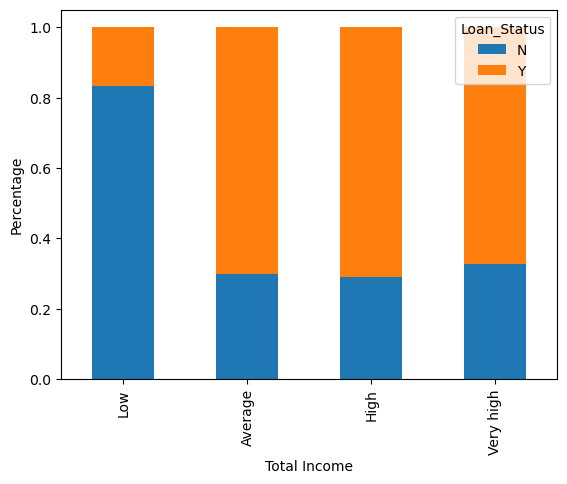

In [21]:
# Let's see the effect of Total Loan Amount on Loan Approval.
bins=[0,2000,4000,6000,81000]
group=['Low','Average','High', 'Very high']
train['Total_Income_bin']=pd.cut(train['TotalIncome'],bins,labels=group)
Total_Income_bin=pd.crosstab(train['Total_Income_bin'],train['Loan_Status'])
Total_Income_bin.div(Total_Income_bin.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.xlabel('Total Income')
plt.ylabel('Percentage')
plt.show()

Higher total income has a positive relation with Loan Approval. So we will not handle the outliers in TotalIncome

In [22]:
# Dropping the temporary column
train=train.drop(['Total_Income_bin'], axis=1)

In [23]:
# Replacing 3+ in Dependents with 3
train['Dependents'].replace('3+', 3,inplace=True)

In [24]:
# Changing the data type of Dependent in train dataset.
train['Dependents'] = train['Dependents'].astype('int64')

In [25]:
# Separating the data into independent and target features
X = train.drop(['Loan_ID','Loan_Status'],axis=1)
y = train['Loan_Status']   

In [26]:
# Label encoding
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
X['Gender']=le.fit_transform(X['Gender'])
X['Married']=le.fit_transform(X['Married'])
X['Education']=le.fit_transform(X['Education'])
X['Self_Employed']=le.fit_transform(X['Self_Employed'])
y=le.fit_transform(y)

In [27]:
# One hot encoding the remaining columns
X = pd.get_dummies(X)    

In [28]:
# Using SMOTE oversampling technique to balance the data.
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=33)
X, y= smote.fit_resample(X, y)

In [29]:
# Scaling the data
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X = std.fit_transform(X)

In [30]:
# Splitting the dataset into train and test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

In [31]:
# Using Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
from sklearn.metrics import accuracy_score
print("Accuracy:",accuracy_score(y_test,y_pred))

Accuracy: 0.7480314960629921


### Bagging

In [32]:
# Using Bagging Classifier with esitmator as Decision Tree
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier()
bag_clf = BaggingClassifier(estimator=tree,n_estimators=100,random_state=42)
bag_clf.fit(X_train,y_train)
y_pred_bag = bag_clf.predict(X_test)
print("Accuracy:",accuracy_score(y_test,y_pred_bag))

Accuracy: 0.8031496062992126


In [33]:
# Using Bagging Classifier with SVM Classifier estimator
from sklearn.svm import SVC
bag_clf2 = BaggingClassifier(estimator=SVC(),n_estimators=100,random_state=42)
bag_clf2.fit(X_train,y_train)
y_pred_bag2 = bag_clf2.predict(X_test)
print("Accuracy:",accuracy_score(y_test,y_pred_bag2))

Accuracy: 0.7677165354330708


In [34]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators=100)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
print("Accuracy:",accuracy_score(y_test,y_pred_rf))

Accuracy: 0.7795275590551181


### Boosting

In [35]:
# AdaBoost Classifier
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(n_estimators=100)
ada_clf.fit(X_train,y_train)
y_pred_ada = ada_clf.predict(X_test)
print("Accuracy:",accuracy_score(y_test,y_pred_ada))

Accuracy: 0.7992125984251969


In [36]:
# Gradient Boost Classifier
from sklearn.ensemble import GradientBoostingClassifier
grad_boost_clf = GradientBoostingClassifier(n_estimators=100,max_depth=3,random_state=42)
grad_boost_clf.fit(X_train,y_train)
y_pred_gb = grad_boost_clf.predict(X_test)
print("Accuracy : ",accuracy_score(y_test,y_pred_gb))

Accuracy :  0.7952755905511811


In [37]:
# XGBooost Classifier
import xgboost as xgb
xg_boost_clf = xgb.XGBClassifier()
xg_boost_clf.fit(X_train,y_train)
y_pred_xgb = xg_boost_clf.predict(X_test)
print("Accuracy : ",accuracy_score(y_test,y_pred_xgb))

Accuracy :  0.7834645669291339


In [38]:
# Display accuracies of all the models.
models = ['Decision Tree', 'Baggin Classifier', 'Bagging Classifier SVC', 'Random Forest', 'Adaboost','Gradient Boost','XG Boost']
accuracy = [accuracy_score(y_test,y_pred),accuracy_score(y_test,y_pred_bag),accuracy_score(y_test,y_pred_bag2),accuracy_score(y_test,y_pred_rf),accuracy_score(y_test,y_pred_ada),accuracy_score(y_test,y_pred_gb),accuracy_score(y_test,y_pred_xgb)]
summary = pd.DataFrame({"Models":models, "Accuracy":accuracy})
summary

,Models,Accuracy
0,Decision Tree,0.748031
1,Baggin Classifier,0.803150
2,Bagging Classifier SVC,0.767717
3,Random Forest,0.779528
4,Adaboost,0.799213
5,Gradient Boost,0.795276
6,XG Boost,0.783465


Bagging Classifier with Decision Tree as the base clasiffier has the best accuracy of 80.31%.